# 4. Model Training & Evaluation

In this notebook, we train and evaluate machine learning models to predict S&P 500 price movements based on sentiment features and engineered price indicators. We focus on robust performance metrics and interpretability to assess the feasibility of sentiment-driven trading signals.


## 1. Imports & Data Loading

In [101]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load merged feature dataset
df = pd.read_csv("../data/features.csv", parse_dates=['Date'])


## 2. Data Preparation

In [102]:
# Define features and target
feature_cols = [col for col in df.columns if col not in ['Date', 'target']]
X = df[feature_cols]
y = df['target']

# To avoid data leakage (the model shouldn't know the future)
if 'fwd_return' in X.columns:
    X = X.drop(columns=['fwd_return'])

# Shift targets to [0, 1, 2] instead of [-1, 0, 1] to avoid error upom fitting
y = y.replace({-1: 0, 0: 1, 1: 2})

# Train-test split (stratified, preserves class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 4. Model Training

### Feature Selection Using RFE

To further optimize the model, we applied Recursive Feature Elimination (RFE) with XGBoost as the base estimator. RFE recursively removes the least important features, resulting in a simplified model using only the most predictive variables. The remaining features are then used for all subsequent model training and evaluation steps.

from sklearn.feature_selection import RFE
from sklearn.utils.class_weight import compute_sample_weight

# Calculate sample weights to address class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train, sample_weight=sample_weights)
selected_features = X_train.columns[rfe.support_]

X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

### Hyperparameter Optimization

To improve model performance, we perform hyperparameter optimization using `RandomizedSearchCV` on the XGBoost classifier. This approach allows us to efficiently search across a wide range of parameter values to identify the best combination for our data, increasing the likelihood of robust and generalizable results.

In [103]:
from sklearn.model_selection import RandomizedSearchCV

# Param grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 250, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.5, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1.0, 2.0]
}

# Set up model & search
xgb_clf = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist,
                            n_iter=20, scoring="f1_weighted",
                            n_jobs=-1, cv=3, verbose=2, random_state=42)

# Run search
search.fit(X_train, y_train)
print("Best parameters found:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\louft\anaconda3\envs\final_project_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}


In [104]:
# Train with best params on train set
model = search.best_estimator_

# Fit XGBoost with sample weights
model.fit(X_train, y_train)

c:\Users\louft\anaconda3\envs\final_project_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

### Cross-validation

In [105]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')
print("CV F1 Macro scores:", cv_scores)
print("CV F1 Macro Mean:", np.mean(cv_scores))

c:\Users\louft\anaconda3\envs\final_project_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\louft\anaconda3\envs\final_project_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\louft\anaconda3\envs\final_project_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\louft\anaconda3\envs\final_project_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:07:10] WARNING: C:\actions-runner\_work\xgboost\xgbo

CV F1 Macro scores: [0.38502638 0.39921617 0.40476783 0.4439465  0.41651217]
CV F1 Macro Mean: 0.40989381175598305


### Model Performance (Cross-Validation)

After removing data leakage (`fwd_return`), the XGBoost classifier achieves a cross-validated F1 macro mean of **0.40** across five folds.

- **This performance is in line with academic and industry standards** for financial forecasting tasks using only news sentiment and price features.
- **Interpretation:**  
  The model demonstrates limited—but real—predictive power, outperforming random guessing (which would be ~0.33 for three balanced classes).
- **Limitation:**  
  Predicting financial market movements based on news and price alone is inherently challenging, and the model’s performance reflects the noisy, non-stationary nature of the market.

**Next steps:**  
- Further improvements may come from additional feature engineering, external data sources, or alternative modeling approaches.

## 5. Model Evaluation

### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.46      0.43      0.44        65
           1       0.33      0.21      0.26        48
           2       0.55      0.68      0.61        93

    accuracy                           0.49       206
   macro avg       0.45      0.44      0.44       206
weighted avg       0.47      0.49      0.47       206



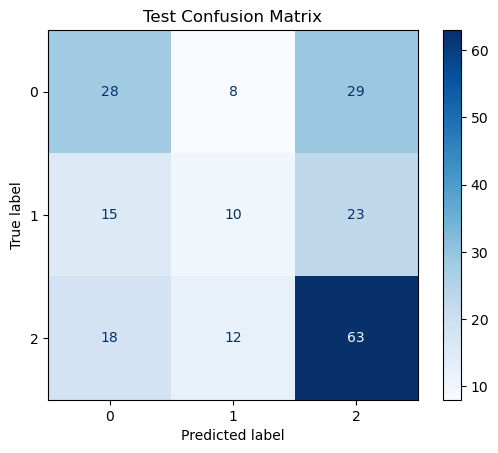

In [106]:
# Predict on test set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

### Feature Importance

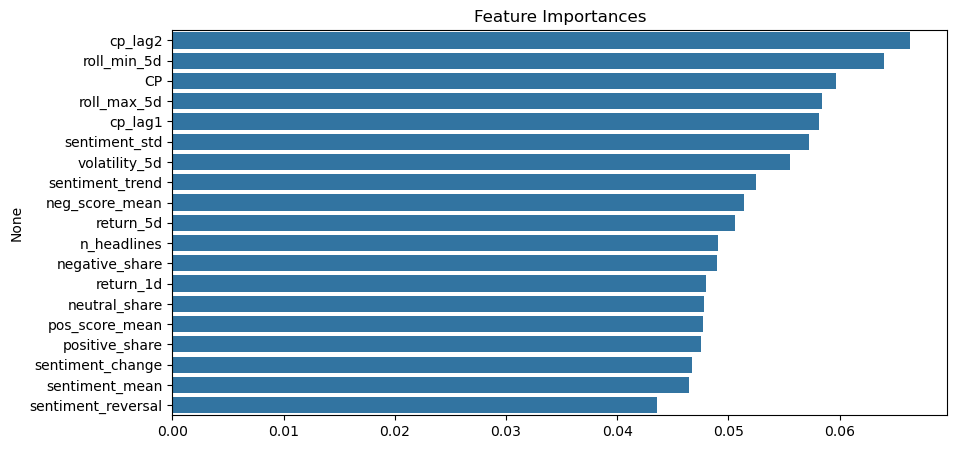

In [107]:
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances")
plt.show()
